In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipdb

from tqdm import tqdm_notebook as tqdm

In [2]:
def make_signal(w, theta, n, skip=1, shift=0):
    """
    Assumes normalized amplitude
    """
    t = np.arange(shift,shift+n*skip,skip)
    signal = np.exp(1j*(w*t + theta))
    return signal

def make_noise(sigma2,n):
    noise_scaling = np.sqrt(sigma2/2)
    # noise is complex valued
    noise  = noise_scaling*np.random.randn(n) + 1j*noise_scaling*np.random.randn(n)
    return noise

def make_noisy_signal(w, theta, sigma2, n, skip=1):
    """
    w: frequency in radians per sample
    theta: phase
    sigma2: noise variance
    n: number of samples
    skip: sampling period
    """
    signal = make_signal(w,theta,n,skip)
    noise  = make_noise(sigma2,n)
    return signal + noise

def get_sigma2_from_snrdb(SNR_db):
    return 10**(-SNR_db/10)

def kay_weights(N):
    scaling = 6.0/N/(N**2 - 1)
    w = [(N-i-1)*(i+1) for i in range(N-1)]
    return scaling*np.array(w)



## Kay's methods

In [3]:
def kays_method1(my_signal, simple_average=False):
    """
    This is the implementation in the paper
    """
    N = len(my_signal)

    if simple_average:
        w = np.ones_like(w)
    else:
        w = kay_weights(N)
        
    angle_diff = np.angle(np.conj(my_signal[0:-1])*my_signal[1:])
#     ipdb.set_trace()
    need_to_shift = np.any(angle_diff < -np.pi/2)
    
    omega = w.dot(angle_diff)
    
    if need_to_shift:   
#         print('needed to shift')
        neg_idx = angle_diff < 0
        omega += np.sum(w[neg_idx]*np.pi*2)
    
    return omega

def kays_method2(my_signal, simple_average=False):
    """
    This is my best implementation
    """
    N = len(my_signal)
        
    if not simple_average:
        w = kay_weights(N)
    else:
        w = np.ones_like(w)
        
    # we will check 4 settings
    t = np.arange(N)
    
    v_best = -np.inf
    omega_best = 0
    for k in range(4):
        rotater = np.exp(-1j*np.pi*k*t/2)
        y = my_signal*rotater
        angle_diff = np.angle(np.conj(y[0:-1])*y[1:])
        omega = w.dot(angle_diff)
        
        y_hat = np.exp(1j*omega*t)
        
        v = np.abs(np.dot(y, np.conj(y_hat)))
        if v > v_best:
            omega_best = (omega + k*np.pi/2) % (2*np.pi)
            v_best = v
    
    return omega_best

def kays_method3(my_signal, simple_average=False):
    """
    This is somewhere in between
    """
    N = len(my_signal)

    if simple_average:
        w = np.ones_like(w)
    else:
        w = kay_weights(N)
        
    angle_diff = np.angle(np.conj(my_signal[0:-1])*my_signal[1:])
    
    rhs = ((angle_diff + np.pi/2) > 0) & ((angle_diff + np.pi/2) < np.pi)
    if np.mean(rhs) > 0.5:
        need_to_shift = False
    else:
        need_to_shift = True
    
#     need_to_shift = np.any(angle_diff < -np.pi/2)
    
    omega = w.dot(angle_diff)
    
    if need_to_shift:   
        neg_idx = angle_diff < 0
        omega += np.sum(w[neg_idx]*np.pi*2)
    
    return omega

kays_method = kays_method2

def successive_estimation(signal_chain, N, p=2, rounding=None):
    location_bis = 0
    num_chains = len(signal_chain)
    # from radians to location
    factor = N/(2*np.pi)
    # how many frequencies wrap to the location
    nwrap = 1
    
    for chain in signal_chain:
        temp_location = (kays_method(chain)*factor) %  N
        loc_update = temp_location/nwrap - location_bis
        r = loc_update - round((loc_update * nwrap)/N)*N/nwrap
        location_bis += r
        nwrap *= p
    location = round(location_bis) % N
    
    if rounding is not None:
        bin_relative_index, F = rounding
        location = (round((location_bis - bin_relative_index)/F)*F + bin_relative_index) % N
        
    return location


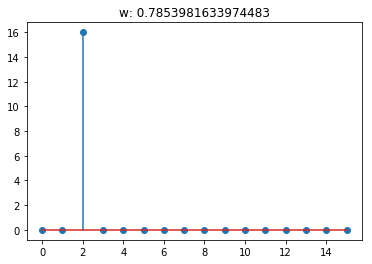

In [4]:
N = 16
f0 = 2
w0 = (2*np.pi)*f0/N % (2*np.pi)


my_signal = make_signal(w0,0,N)
my_signal_fft = np.fft.fft(my_signal)

plt.stem(np.abs(my_signal_fft))
plt.title('w: {}'.format(w0))
plt.show()

In [5]:
def omega_to_location(w,N):
    return w*(N/(2*np.pi))

In [6]:
omega_to_location(kays_method(my_signal),N)

2.0

In [7]:
from functools import reduce

In [8]:
def make_successive_estimation_sampling_chains(num_chains, 
                                               num_samples_per_chain, 
                                               N, 
                                               p=2, 
                                               random_start=False):
    """
    This function makes sampling points for successive estimation method
    """
    chains_sp = []
    
    for i in range(num_chains):
        # ith chain gets skips of p**i
        skip = p**i
        if random_start:
            start_location = np.random.choice(N)
        else:
            start_location = 0
        
        sp = np.arange(start_location, 
                       start_location+skip*num_samples_per_chain, 
                       skip)
        sp = sp % N
        chains.append(sp)
    return chains
    
    

def make_kay_chains(w0, num_chains, num_samples_per_chain, snrdb, p=2):
    """
    Function to make chains for successive estimation using Kay's method
    """
    # this is a list of arrays
    # it has num_chains many elements
    # each element is an array of length num_samples_per_chain
    chains = []
    # noise variance
    sigma2 = get_sigma2_from_snrdb(snrdb)
    
    for i in range(num_chains):
        # first chain gets samples with skipping 1
        # second chain gets samples with skipping 2, etc...
        skip = p**i
        # skip needs to be passed
        noisy_signal = make_noisy_signal(w=w0,
                                         theta=0,
                                         sigma2=sigma2,
                                         n=num_samples_per_chain,
                                         skip=skip)
        
        # append to the chain
        chains.append(noisy_signal)
    return chains

def make_our_chains(w0,
                    n,
                    num_pairs_per_chain,
                    snrdb,
                    prime_base=2,
                    num_samples_per_pair=2,
                    other_factor=1):
    '''
    n = what power of two is the signal
    '''
    # chains is a list of lists
    # it has n elements
    # each element is a list of tuples (sample1, sample2)
    chains = []
    # sampling_points is a list of lists
    # it has n elements
    # each element is a list of tuples (sampling_location_1, sampling_location_2)
    sampling_points = []
    sigma2 = get_sigma2_from_snrdb(snrdb)
    
    # you start by skipping signal_length/2
    skip = other_factor*prime_base**(n-1)
    
    for i in range(n):
        current_chain = []
        current_sampling_points = []
        
        # poisition of the first sample
        shift = 0
        for i in range(num_pairs_per_chain):
            signal = make_signal(w0,0,num_samples_per_pair,skip,shift)
            noise  = make_noise(sigma2,num_samples_per_pair)
            noisy_signal = signal + noise
            current_chain.append(tuple(noisy_signal))
            current_sampling_points.append(tuple([shift + i*skip for i in range(num_samples_per_pair)]))
            shift += 1
        chains.append(current_chain)
        sampling_points.append(current_sampling_points)
        # halve the skip
        skip /= prime_base
    return chains, sampling_points

# make chain
# make sub chains

def make_our_locations(n,
                       num_pairs_per_chain,
                       prime_base=2,
                       num_samples_per_pair=2,
                       other_factor=1):
    '''
    n = what power of two is the signal
    '''
    # chains is a list of lists
    # it has n elements
    # each element is a list of tuples (sample1, sample2)
    chains = []
    # sampling_points is a list of lists
    # it has n elements
    # each element is a list of tuples (sampling_location_1, sampling_location_2)
    sampling_points = []
    
    # you start by skipping signal_length/2
    skip = other_factor*prime_base**(n-1)
    
    for i in range(n):
        current_sampling_points = []
        
        # poisition of the first sample
        shift = 0
        for i in range(num_pairs_per_chain):
            current_sampling_points.append(tuple([shift,shift+skip]))
            shift += 1
        sampling_points.append(current_sampling_points)
        # halve the skip
        skip /= prime_base
    return sampling_points

def estimate_bit_diff(chain,
                      sampling_points,
                      ref_w0):
    '''
    chain: pairs of samples obtained from the chain
    sampling_points: the points at which the samples are obtained
    ref_w0: the reference frequency obtained so far
    '''
    # complex valued estimate of the sign
    d = 0
    # number of pairs in a chain
    len_chain = len(chain)
    # go over the chain
    for i in range(len_chain):
        # where the samples are taken
        s1,s2 = sampling_points[i]
        # the sample values
        a,b = chain[i]
        # rotate the frequency based on the reference
        a = a*np.exp(-1j*ref_w0*s1)
        b = b*np.exp(-1j*ref_w0*s2)
        # check the sign
        d += (b - a)
    # average the sign
    # (this would change if there is a covariance between estimates)
    # (we get around this by taking non-overlapping samples)
    d /= len_chain
    
    # sign (returns -1 or 1)
    estimated_sign = np.sign(np.real(d) + 1)
    
    
#     print('jump: {} - {} = {}'.format(s2,s1,s2-s1))
#     print(d + 1)
#     print('sign: {}'.format(estimated_sign))
    return estimated_sign

def estimate_bit(chain,
                 sampling_points,
                 ref_w0,
                 prime_base=2):
    '''
    chain: pairs of samples obtained from the chain
    sampling_points: the points at which the samples are obtained
    ref_w0: the reference frequency obtained so far
    p: prime that is equal to the base
    '''
    # complex valued estimate of the sign
    d = 0
    # number of pairs in a chain
    len_chain = len(chain)
    # go over the chain
    for i in range(len_chain):
        # where the samples are taken
        s1,s2 = sampling_points[i]
        # the sample values
        a,b = chain[i]
        # rotate the frequency based on the reference
        a = a*np.exp(-1j*ref_w0*s1)
        b = b*np.exp(-1j*ref_w0*s2)
        # check the sign
        d += b*np.conj(a)
    # average the sign
    # (this would change if there is a covariance between estimates)
    # (we get around this by taking non-overlapping samples)
    d /= len_chain
    
    # rotate according to decision boundaries
    # we need to rotate by 2pi/(2prime_base)
    # this is to make one of the boundaries of the
    # voronoi cells touch the positive side of x-axis
    # so we can just return the integer part of a number
    # to get the bit
    d *= np.exp(1j*np.pi/prime_base)
    # get the angle and normalize by 2pi
    angle = np.angle(d)/2/np.pi
    # angle is between (-0.5,0.5), take
    # the mod to make it between (0,1)
    angle = angle % 1
    # return which voronoi cell the angle falls into
    # it falls to gaps of 1/prime_base so multiply
    # with prime base and get the integer part
    return int(angle*prime_base)

def estimate_bit_ml(chain,
                    sampling_points,
                    ref_w0,
                    prime_base=2,
                    statistics_function=np.real):
    '''
    chain:               pairs of samples obtained from the chain
    sampling_points:     the points at which the samples are obtained
    ref_w0:              the reference frequency obtained so far
    p:                   prime that is equal to the base
    statistics_function: when we know the amplitude we can use np.real 
                         as the statistics function.  However, when the
                         coefficient is not known, we need to use np.abs
    '''
    # number of pairs in a chain
    len_chain = len(chain)
    max_inprod = -np.inf
    best_loc = 0
    
    # these were sampling_points[0] and chain[0]
    # sampling_points = np.array(sampling_points)
    # chain = np.array(chain)
    
    rotater = np.exp(-1j*ref_w0*sampling_points)
    chain = chain*rotater
    
    # go over possible bits
    t = np.arange(len(sampling_points))
    for l in range(prime_base):
        steering_vector = np.exp(-1j*2*np.pi*l*t/prime_base)
        current_inprod = chain.dot(steering_vector)
        # can we look at the real part here when we have 
        # phase in the problem or equivalently there is a
        # coefficient in front of the tone.  If we change 
        # this to abs we loose a lot of performance in terms
        # of the number of samples
        if statistics_function(current_inprod) > max_inprod:
            max_inprod = statistics_function(current_inprod)
            best_loc = l
    return int(best_loc)

def estimate_bit_sub_ml(chain,
                        sampling_points,
                        ref_w0,
                        prime_base=2,
                        statistics_function=np.median):
    '''
    chain: signal samples (list of arrays)
    sampling_points: the points at which the samples are obtained (list of arrays)
    ref_w0: the reference frequency obtained so far
    p: prime that is equal to the base
    '''
    # here we assume there are multiple pairs per chain
    # so we cannot do single chain computation like the
    # ml version
    # this is the number of sub-chains
    len_chain = len(chain)
    max_metric = -np.inf
    best_loc = 0
    t = np.arange(len(sampling_points[0]))
    # go over possible bits
    for l in range(prime_base):
        sum_metric = 0
        steering_vector = np.exp(-1j*2*np.pi*l*t/prime_base)
        
        the_inprods = []
        # go over the sub-chains
        for batch, sp in zip(chain,sampling_points):
            # we need to use this rotater!
            rotater = np.exp(-1j*ref_w0*sp)
            batch = batch*rotater
            current_inprod = batch.dot(steering_vector)
            the_inprods.append(np.abs(current_inprod))
        
        sum_metric = statistics_function(the_inprods)
        
        if sum_metric > max_metric:
            max_metric = sum_metric
            best_loc = l
    return int(best_loc)

def get_correlation_with_steering_vector(yx, sp, w0, sv):
    rotater = np.exp(-1j*w0*sp)
    yx = yx*rotater
    current_inprod = yx.dot(sv)
    return current_inprod
    

def our_method(all_chains,
               all_sampling_points,
               prime_base=2,
               bin_estimator=estimate_bit):
    # start with reference 0
    ref_w0 = 0
    n = len(all_chains)
    # signal length
    N = prime_base**n
    # go over chains
    for i in range(n):
        current_chain = all_chains[i]
        current_smapling_points = all_sampling_points[i]
        # estimate the bit
        current_bit = bin_estimator(current_chain,
                                    current_smapling_points,
                                    ref_w0,
                                    prime_base)
        # if the current bit is -1 it means we are odd with
        # respect to ith bit of the frequency
        ref_w0 += current_bit*(prime_base**i)*(2*np.pi)/N
    return ref_w0

# sampler

In [9]:
class Sampler:
    def __init__(self, w, theta, sigma2):
        self.w = w
        self.theta = theta
        self.sigma2 = sigma2
        self.noise_scaling = np.sqrt(sigma2/2)
    
    def sample(self, n):
        signal = np.exp(1j*(self.w*n+ self.theta))
        noise  = noise_scaling*np.random.randn(n) + 1j*noise_scaling*np.random.randn(n)
        return signal+noise
        
class OnePeriodSampler:
    def __init__(self, w, theta, sigma2):
        self.w = w
        self.theta = theta
        self.sigma2 = sigma2
        self.noise_scaling = np.sqrt(sigma2/2)
        self.already_generated = {}
    
    def sample(self, n):
        if n in self.already_generated:
            return self.already_generated[n]
        else:
            signal = np.exp(1j*(self.w*n+ self.theta))
            noise  = noise_scaling*np.random.randn(n) + 1j*noise_scaling*np.random.randn(n)
            return signal+noise

# test 1

Here I test our algorithm under independent noise and infinite-length signal setting

In [10]:
def run_many(f, num_iter, **kwargs):
    r = []
    for i in range(num_iter):
        r.append(f(**kwargs))
    return r

In [11]:
def test_ml(p, n, samples_per_chain, f0, snrdb, statistics_function=np.real, premake=False):
    """
    Make the one with the signal pre-made.
    """
    N = p**n
    w0 = (2*np.pi)*f0/N
    s2 = get_sigma2_from_snrdb(snrdb)
    
    # this is the setting where we are given a single period from the signal
    if premake:
        x = make_noisy_signal(w0, theta=0, sigma2=s2, n=N, skip=1)
    
    c_so_far = 0
    for chain in range(n):
        skip = p**(n-1-chain)
        ref_w0 = (2*np.pi)*c_so_far/N
        if not premake:
            y = make_noisy_signal(w0, theta=0, sigma2=s2, n=samples_per_chain, skip=skip)
            sampling_points = np.arange(0, samples_per_chain*skip, skip)
        else:
            random_shift = np.random.choice(N)
            sampling_points = np.arange(random_shift, samples_per_chain*skip+random_shift, skip)
            sampling_points = sampling_points % N
            y = x[sampling_points]
            
        bit = estimate_bit_ml(y, sampling_points, ref_w0, prime_base=p, statistics_function=statistics_function)
        c_so_far += bit * (p**chain)
    
    return int(c_so_far == f0)

def test_sub_ml(p, n, samples_per_chain, num_chains, f0, snrdb, statistics_function=np.median, alternate=False):
    N = p**n
    w0 = (2*np.pi)*f0/N
    s2 = get_sigma2_from_snrdb(snrdb)
    
    c_so_far = 0
    for chain in range(n):
        skip = p**(n-1-chain)
        ref_w0 = (2*np.pi)*c_so_far/N
        
        current_samples = []
        current_sampling_points = []
        
        # make this using map function instead to speed up the computations
        for sub_chain in range(num_chains):
            y = make_noisy_signal(w0, theta=0, sigma2=s2, n=samples_per_chain, skip=skip)
            t = np.arange(0, samples_per_chain*skip, skip)
            current_samples.append(y)
            current_sampling_points.append(t)
        
        bit = estimate_bit_sub_ml(current_samples,
                                  current_sampling_points, 
                                  ref_w0,
                                  prime_base=p,
                                  statistics_function=statistics_function)
        
        c_so_far += bit * (p**chain)
        
        if alternate:
            if num_chains > 2:
                num_chains = max(num_chains // 2, 1)
                samples_per_chain = samples_per_chain * 2
    
    return int(c_so_far == f0)

def test_mixed_ml(p, n, m, f0, snrdb, statistics_function):
    """
    p:  prime factor
    n:  power of the prime
    m:  initial number of bits to recover
    f0: 
    snrdb:
    summing_power:
    """
    N = p**n
    w0 = (2*np.pi)*f0/N
    s2 = get_sigma2_from_snrdb(snrdb)
    
    c_so_far = 0
    skip = None
    num_recovered_bits = 0
    
    samples_per_chain = p**m
    
    while num_recovered_bits < n:
        if num_recovered_bits == 0:
            skip = p**(n-m)
            current_recovered_bits = m
        else:
            skip = p**(n-num_recovered_bits-1)
            current_recovered_bits = 1
            
        ref_w0 = (2*np.pi)*c_so_far/N
        
        current_samples = []
        current_sampling_points = []
        

        y = make_noisy_signal(w0, theta=0, sigma2=s2, n=samples_per_chain, skip=skip)
        t = np.arange(0, samples_per_chain*skip, skip)
        current_samples.append(y)
        current_sampling_points.append(t)
        
        bit = estimate_bit_sub_ml(current_samples,
                                  current_sampling_points, 
                                  ref_w0,
                                  prime_base=p**current_recovered_bits,
                                  statistics_function=statistics_function)
        
        c_so_far += bit * (p**num_recovered_bits)
        
    
        num_recovered_bits += current_recovered_bits
    return int(c_so_far == f0)

def test_kays(p, n, num_samples, f0, snrdb):
    N = p**n
    w0 = (2*np.pi)*f0/N
    s2 = get_sigma2_from_snrdb(snrdb)
    
    y = make_noisy_signal(w0, theta=0, sigma2=s2, n=num_samples, skip=1)
    freq = kays_method(y)
    
    return freq

def test_successive_estimation(p, n, samples_per_chain, num_chains, f0, snrdb, summing_power=1):
    N = p**n
    w0 = (2*np.pi)*f0/N
    s2 = get_sigma2_from_snrdb(snrdb)
    
    chains = make_kay_chains(w0, num_chains, samples_per_chain, snrdb, p=2)
    f0_hat = successive_estimation(chains, N, p=2, rounding=None)
    
    return int(f0_hat == f0)


def test_linear_ml(p, n, samples_per_chain, f0, snrdb, sampling_method='random'):
    """
    Make the one with the signal pre-made.
    sampling_method: [random, arange]
    """
    N = p**n
    w0 = (2*np.pi)*f0/N
    s2 = get_sigma2_from_snrdb(snrdb)
    
    if sampling_method == 'random':
        sampling_points = np.random.choice(N, samples_per_chain, replace=False)
    elif sampling_method == 'arange':
        sampling_points = np.arange(samples_per_chain)
    else:
        print('do not know the sampling method')
    
    signal = np.exp(1j*(w0*sampling_points))
    noise  = make_noise(s2, samples_per_chain)
    noisy_signal = signal + noise
    
    y = np.zeros(N, dtype=np.complex)
    y[sampling_points] = noisy_signal
    
    v = np.fft.fft(y)
    v = np.abs(v)
    
    k_hat = np.argmax(v)
    
    return int(k_hat == f0)

In [12]:
test_kays(p=2, n=20, num_samples=200, f0=0, snrdb=0)*(2**20)/2/np.pi

535612.4424541596

In [13]:
kays_method = kays_method3

In [14]:
f0 = 2**9-1
n = 20
snrdb = -10

In [15]:
# successive estimation
# I observe that frequency location 0 is very well found with
# samples per chain=200
# snrdb=0
# f0=0
# for any other f0 it is around 1/4.

q = run_many(test_successive_estimation, 1000, p=2, n=n, samples_per_chain=256, 
             num_chains=n, f0=f0, snrdb=snrdb)
np.mean(q)

0.154

In [16]:
# ML multi-period
q = run_many(test_ml, 1000, p=2, n=n, samples_per_chain=256, f0=f0,
             statistics_function=np.abs, snrdb=snrdb, premake=False)
np.mean(q)

1.0

In [17]:
# ML single period
q = run_many(test_ml, 1000, p=2, n=n, samples_per_chain=2, f0=f0,
             statistics_function=np.abs, snrdb=snrdb, premake=True)
np.mean(q)

0.0

In [18]:
# Sub-ML multi-period
# my_function = lambda x: np.mean(np.array(x)**2)
my_function = lambda x: np.mean(x)
# my_function = lambda x: np.mean(np.sqrt(x))
# my_function = lambda x: np.median(x)
q = run_many(test_sub_ml, 1000, p=2, n=n, samples_per_chain=2, num_chains=256,
             f0=f0, snrdb=snrdb, statistics_function=my_function, alternate=True)
np.mean(q)

0.976

In [19]:
from statsmodels.stats.proportion import proportion_confint

In [20]:
proportion_confint(len(q), len(q), alpha=0.05, method='beta')

(0.9963179161031334, 1)

## collecting data for plot generation

Fixed SNR and signal length, but changing the number of samples

This is slow -- you might want to skip this part if you are looking for something else

In [21]:
import pandas as pd

In [22]:
df = pd.DataFrame(columns=['method','p','n','f0','snrdb','samples_per_chain','num_chains','iter','success'])

In [23]:
num_iter = 10000
p = 2
n = 20
f0 = 23
snrdb = 0

In [24]:
# bit ML
for samples_per_chain in tqdm(np.arange(1,10)*2):
    q = run_many(test_ml, num_iter, p=p, n=n, samples_per_chain=samples_per_chain, f0=f0, snrdb=snrdb)
    
    entry = {'method':'ml', 'p':p, 'n':n, 'f0':f0, 'snrdb':snrdb, 'samples_per_chain':samples_per_chain, 'num_chains':1, 'iter':num_iter, 'success':sum(q)}
    df = df.append(entry, ignore_index=True)

In [25]:
# bit MLUK
for samples_per_chain in tqdm(np.arange(1,10)*2):
    q = run_many(test_ml, num_iter, p=p, n=n, samples_per_chain=samples_per_chain, f0=f0, snrdb=snrdb, statistics_function=np.abs)
    
    entry = {'method':'mluk', 'p':p, 'n':n, 'f0':f0, 'snrdb':snrdb, 'samples_per_chain':samples_per_chain, 'num_chains':1, 'iter':num_iter, 'success':sum(q)}
    df = df.append(entry, ignore_index=True)

In [26]:
# bit sub ML
samples_per_chain = p
for num_chains in tqdm(range(1,20,1)):
    q = run_many(test_sub_ml, num_iter, 
                 p=p, 
                 n=n, 
                 samples_per_chain=samples_per_chain, 
                 num_chains=num_chains, 
                 f0=f0, 
                 snrdb=snrdb,
                 statistics_function=np.mean)
    
    entry = {'method':'subml', 'p':p, 'n':n, 'f0':f0, 'snrdb':snrdb, 'samples_per_chain':samples_per_chain, 'num_chains':num_chains, 'iter':num_iter, 'success':sum(q)}
    df = df.append(entry, ignore_index=True)

KeyboardInterrupt: 

In [27]:
df['total_samples'] = df['samples_per_chain']*df['num_chains']
df['success_prob'] = df['success']/df['iter']

In [28]:
df

,method,p,n,f0,snrdb,samples_per_chain,num_chains,iter,success,total_samples,success_prob
0,ml,2,20,23,0,2,1,10000,1950,2,0.195
1,ml,2,20,23,0,4,1,10000,6369,4,0.6369
2,ml,2,20,23,0,6,1,10000,8596,6,0.8596
3,ml,2,20,23,0,8,1,10000,9507,8,0.9507
4,ml,2,20,23,0,10,1,10000,9832,10,0.9832
5,ml,2,20,23,0,12,1,10000,9950,12,0.995
6,ml,2,20,23,0,14,1,10000,9983,14,0.9983
7,ml,2,20,23,0,16,1,10000,9994,16,0.9994
8,ml,2,20,23,0,18,1,10000,9997,18,0.9997
9,mluk,2,20,23,0,2,1,10000,173,2,0.0173


there is an error in the sub-ml code, in the beginning increasing the number of samples seem to hurt!

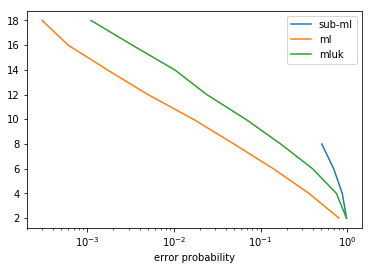

In [29]:
subml_data = df[df['method'] == 'subml']
ml_data = df[df['method'] == 'ml']
mluk_data = df[df['method'] == 'mluk']
plt.semilogx(1-subml_data['success_prob'], subml_data['total_samples'], label='sub-ml')
plt.semilogx(1-ml_data['success_prob'], ml_data['total_samples'], label='ml')
plt.semilogx(1-mluk_data['success_prob'], mluk_data['total_samples'], label='mluk')
plt.legend()
plt.xlabel('error probability')
plt.show()

In [30]:
def write_data(outfile, column_names, *args):
    with open(outfile, 'w') as out:
        out.write(' '.join(column_names) + '\n')
        for z in zip(*args):
            z = [str(zi) for zi in z]
            out.write(' '.join(z))
            out.write('\n')

In [31]:
write_data('plotting/experiment-1/out-ml.txt', 
           ['d','m'], 
           np.array(1-ml_data['success_prob']), 
           np.array(ml_data['total_samples']))

FileNotFoundError: [Errno 2] No such file or directory: 'plotting/experiment-1/out-ml.txt'

In [32]:
write_data('plotting/experiment-1/out-mluk.txt', 
           ['d','m'], 
           np.array(1-mluk_data['success_prob']), 
           np.array(mluk_data['total_samples']))

FileNotFoundError: [Errno 2] No such file or directory: 'plotting/experiment-1/out-mluk.txt'

In [33]:
write_data('plotting/experiment-1/out-subml.txt',
           ['d','m'], 
           np.array(1-subml_data['success_prob']), 
           np.array(subml_data['total_samples']))

FileNotFoundError: [Errno 2] No such file or directory: 'plotting/experiment-1/out-subml.txt'

# testing icassp 2019 method

In [34]:
2**30

1073741824

In [35]:
# for testing our method
n = 20
p = 2
f0 = 10
snrdb = 2

N = p**n
w0 = (2*np.pi)*f0/N
s2 = get_sigma2_from_snrdb(snrdb)

num_correct = 0
num_iter = 1000

# samples_per_chain = int(np.ceil(2*s2*np.log(n*p/0.05)))
samples_per_chain = 6
print('samples per chain: {}'.format(samples_per_chain))
print('total samples: {}'.format(n*samples_per_chain))

for i in range(num_iter):
    c_so_far = 0
    for chain in range(n):
        skip = p**(n-1-chain)
        ref_w0 = (2*np.pi)*c_so_far/N
        y = make_noisy_signal(w0, theta=0, sigma2=s2, n=samples_per_chain, skip=skip)
        sampling_points = np.arange(0, samples_per_chain*skip, skip)
        bit = estimate_bit_ml(y, sampling_points, ref_w0, prime_base=p)
        c_so_far += bit * (p**chain)
    num_correct += (c_so_far == f0)
    
print('success: {}'.format(num_correct/num_iter))

samples per chain: 6
total samples: 120
success: 0.972


# plot in kay's paper

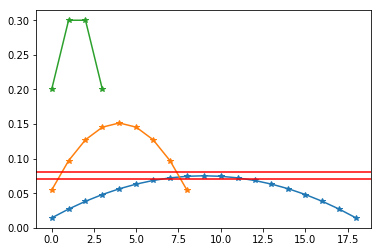

In [36]:
plt.plot(kay_weights(20),'-*')
plt.plot(kay_weights(10),'-*')
plt.plot(kay_weights(5),'-*')
plt.axhline(0.07, c='r')
plt.axhline(0.08, c='r')
# plt.ylim([0.01,0.10])
plt.show()

Kay as a function of number of samples

var: 1.817971660802398e-05


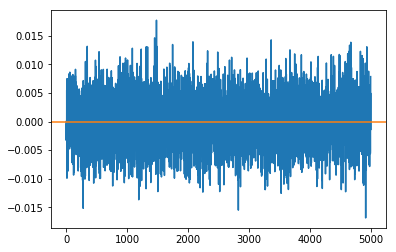

In [37]:
p = 2
n = 20
f0 = 0

r = run_many(test_kays, 5000, p=p, n=n, num_samples=15, f0=f0, snrdb=20)
print('var: {}'.format( np.mean((np.array(r) - 2*np.pi*f0/(p**n))**2) ))
plt.plot(r)
plt.axhline(2*np.pi*f0/(p**n), color='C1')
plt.show()

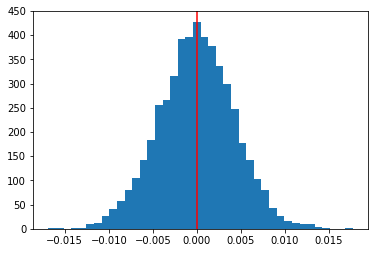

In [38]:
plt.hist(r,bins=40)
plt.axvline(0,color='r')
plt.show()

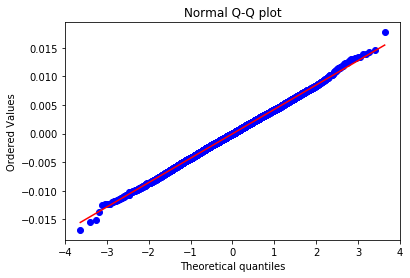

In [39]:
import scipy.stats as stats


stats.probplot(r, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

In [40]:
kays_method = kays_method3
run_many(test_kays, 1, p=4, n=1, num_samples=4, f0=3, snrdb=30)

[4.703434135734248]

In [41]:
run_many(test_kays, 1, p=8, n=1, num_samples=4, f0=7, snrdb=30)

[-0.7809839389823556]

In [42]:
def calc_error(r, ref):
    angle_diff = np.angle(np.exp(1j*r)*np.conj(ref))
    return np.mean((angle_diff/2/np.pi)**2)

In [43]:
f0 = 1
p = 20
n = 1
N = p**n

snrdb_points = np.linspace(-10,40,80)

In [44]:
results = []
kays_method = kays_method1
for snrdb in tqdm(snrdb_points):
    r = run_many(test_kays, 1000, p=p, n=n, num_samples=100, f0=f0, snrdb=snrdb)
    results.append(np.array(r))
    
rs = [0 for i in range(len(results))]
for i in range(len(results)):
    rs[i] = calc_error(results[i], np.exp(1j*2*np.pi*f0/N))

Setting for kay's plots is:
`r = run_many(test_kays, 100, p=20, n=1, num_samples=24, f0=f0, snrdb=snrdb)`

In [45]:
results_2 = []
kays_method = kays_method2
for snrdb in tqdm(snrdb_points):
    r = run_many(test_kays, 1000, p=p, n=n, num_samples=100, f0=f0, snrdb=snrdb)
    results_2.append(np.array(r))
    

rs_2 = np.array([calc_error(u, np.exp(1j*2*np.pi*f0/N)) for u in results_2])

In [46]:
results_3 = []
kays_method = kays_method3
for snrdb in tqdm(snrdb_points):
    r = run_many(test_kays, 1000, p=p, n=n, num_samples=100, f0=f0, snrdb=snrdb)
    results_3.append(np.array(r))
    

rs_3 = np.array([calc_error(u, np.exp(1j*2*np.pi*f0/N)) for u in results_3])

In [47]:
def to_db(u):
    return 10*np.log10(u)

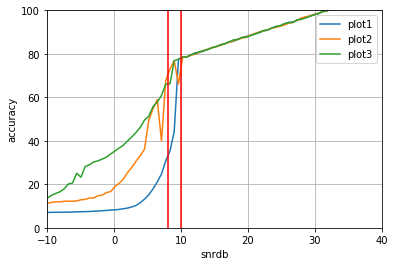

In [48]:
rs = np.array(rs)
rs_2 = np.array(rs_2)
rs_3 = np.array(rs_3)

plt.plot(snrdb_points, to_db(1/rs), label='plot1')
plt.plot(snrdb_points, to_db(1/rs_2), label='plot2')
plt.plot(snrdb_points, to_db(1/rs_3), label='plot3')
plt.axvline(8, c='r')
plt.axvline(10, c='r')
plt.xlabel('snrdb')
plt.ylabel('accuracy')
plt.legend()
plt.ylim([0,100])
plt.xlim([-10,40])
plt.grid(True)
plt.show()

I observe 10db per decade decrease until 6 db, then 20db per decade.  How about our algorithm?

## new method vs. kay's probability

This is where we compare our method to Kay's method for a single bit estimation, that is for $n=1$.

In [176]:
snrdb_points = np.linspace(-20,10,61)

In [177]:
snrdb_points

array([-20. , -19.5, -19. , -18.5, -18. , -17.5, -17. , -16.5, -16. ,
       -15.5, -15. , -14.5, -14. , -13.5, -13. , -12.5, -12. , -11.5,
       -11. , -10.5, -10. ,  -9.5,  -9. ,  -8.5,  -8. ,  -7.5,  -7. ,
        -6.5,  -6. ,  -5.5,  -5. ,  -4.5,  -4. ,  -3.5,  -3. ,  -2.5,
        -2. ,  -1.5,  -1. ,  -0.5,   0. ,   0.5,   1. ,   1.5,   2. ,
         2.5,   3. ,   3.5,   4. ,   4.5,   5. ,   5.5,   6. ,   6.5,
         7. ,   7.5,   8. ,   8.5,   9. ,   9.5,  10. ])

In [178]:
def calc_acc(omegas, p, f0):
    omegas = omegas/(2*np.pi)
    omegas = (omegas+1/(p*2)) % 1
    f0_hat = np.floor(omegas*p)
    return np.mean(f0_hat == f0)
    

In [179]:
samples_per_chain = 2
num_chains = 1

kay_samples = samples_per_chain*num_chains
new_samples = kay_samples

f0 = 0
p = 2
n = 1
N = p**n

In [180]:
results = []
kays_method = kays_method2
for snrdb in tqdm(snrdb_points):
    r = run_many(test_kays, 
                 1000, 
                 p=p, 
                 n=n, 
                 num_samples=kay_samples, 
                 f0=f0, 
                 snrdb=snrdb)
    results.append(np.array(r))
    
rs = [0 for i in range(len(results))]
for i in range(len(results)):
    rs[i] = calc_acc(results[i], p, f0)

In [181]:
rs_2 = []
for snrdb in tqdm(snrdb_points):
    # Sub-ML multi-period
    q = run_many(test_sub_ml, 
                 1000, 
                 p=p, 
                 n=n, 
                 samples_per_chain=samples_per_chain, 
                 num_chains=num_chains,
                 f0=f0, 
                 snrdb=snrdb, 
                 statistics_function=np.mean, 
                 alternate=True)
    rs_2.append(np.mean(q))

In [182]:
rs_3 = []
for snrdb in tqdm(snrdb_points):
    # Sub-ML multi-period
    q = run_many(test_sub_ml, 
                 1000, 
                 p=p, 
                 n=n, 
                 samples_per_chain=new_samples, 
                 num_chains=1,
                 f0=f0, 
                 snrdb=snrdb, 
                 statistics_function=np.mean, 
                 alternate=True)
    rs_3.append(np.mean(q))

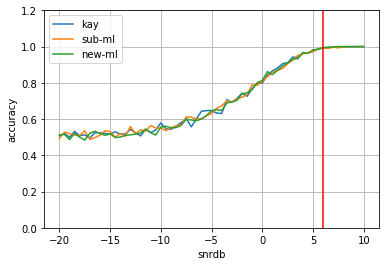

In [183]:
rs = np.array(rs)
rs_2 = np.array(rs_2)
rs_3 = np.array(rs_3)

plt.plot(snrdb_points, rs, label='kay')
plt.plot(snrdb_points, rs_2, label='sub-ml')
plt.plot(snrdb_points, rs_3, label='new-ml')
plt.axvline(6, c='r')
plt.xlabel('snrdb')
plt.ylabel('accuracy')
plt.legend()
plt.ylim([0,1.2])
plt.grid(True)
plt.show()

In [184]:
d = pd.DataFrame(list(zip(snrdb_points, rs, rs_2, rs_3)), columns=['snrdb', 'kay', 'sub-ml', 'new-ml'])
print(d.iloc[35:45])

    snrdb    kay  sub-ml  new-ml
35   -2.5  0.714   0.713   0.703
36   -2.0  0.743   0.720   0.740
37   -1.5  0.726   0.736   0.745
38   -1.0  0.768   0.789   0.763
39   -0.5  0.798   0.787   0.801
40    0.0  0.799   0.809   0.813
41    0.5  0.844   0.834   0.862
42    1.0  0.866   0.858   0.845
43    1.5  0.882   0.868   0.870
44    2.0  0.906   0.880   0.893


## successive refinement probability

In [185]:
snrdb_points = np.linspace(-20,20,30)

p = 2
# n = 20
n = 8
N = p**n

f0 = N//2 + 1

In [186]:
new_ml_samples_per_chain = 10
total_samples = n*new_ml_samples_per_chain
kay_samples_per_chain = new_ml_samples_per_chain
linear_ml_samples = total_samples

print('total samples: {}'.format(total_samples))

signal_length = p**n
print('sampling rate: {}%'.format(100*total_samples/signal_length))




total samples: 80
sampling rate: 31.25%


In [187]:
rs_kay1 = []
kays_method = kays_method1

samples_per_chain = kay_samples_per_chain
print('total samples: {}'.format(samples_per_chain*n))

for snrdb in tqdm(snrdb_points):
    q = run_many(test_successive_estimation,
                 1000, 
                 p=p, 
                 n=n, 
                 samples_per_chain=samples_per_chain, 
                 num_chains=n, 
                 f0=f0, 
                 snrdb=snrdb)
    rs_kay1.append(np.mean(q))

total samples: 80


In [188]:
rs = []
kays_method = kays_method2

samples_per_chain = kay_samples_per_chain
print('total samples: {}'.format(samples_per_chain*n))

for snrdb in tqdm(snrdb_points):
    q = run_many(test_successive_estimation,
                 1000, 
                 p=p, 
                 n=n, 
                 samples_per_chain=samples_per_chain, 
                 num_chains=n, 
                 f0=f0, 
                 snrdb=snrdb)
    rs.append(np.mean(q))

total samples: 80


In [189]:
rs_ml = []

samples_per_chain = new_ml_samples_per_chain
print('total samples: {}'.format(samples_per_chain*n))

for snrdb in tqdm(snrdb_points):
    # Sub-ML multi-period
    q = run_many(test_sub_ml, 
                 1000, 
                 p=p, 
                 n=n, 
                 samples_per_chain=samples_per_chain, 
                 num_chains=1,
                 f0=f0, 
                 snrdb=snrdb, 
                 statistics_function=np.mean, 
                 alternate=False)
    rs_ml.append(np.mean(q))

total samples: 80


In [203]:
# p = 2
# n = 20
# f0 = 2**(n-2)
# N = p**n

rs_mixed = []

m = 3
print('total samples: {}'.format((n-m+1)*p**m))

for snrdb in tqdm(snrdb_points):
    # Sub-ML multi-period
    q = run_many(test_mixed_ml, 1000, p=p, n=n, m=m,
                 f0=f0, snrdb=snrdb, statistics_function=np.mean)
    rs_mixed.append(np.mean(q))

total samples: 48


In [198]:
rs_linear_ml = []

samples_per_chain = linear_ml_samples
print('total samples: {}'.format(samples_per_chain))

for snrdb in tqdm(snrdb_points):
    # Sub-ML multi-period
    q = run_many(test_linear_ml, 1000, p=p, n=n, samples_per_chain=samples_per_chain, f0=f0, snrdb=snrdb)
    rs_linear_ml.append(np.mean(q))

total samples: 80


In [194]:
# p = 2
# n = 20
# f0 = 2**(n-2)
# N = p**n

# rs_2 = []


# samples_per_chain = p
# num_chains = 16
# print('total samples: {}'.format(samples_per_chain*num_chains*n))

# for snrdb in tqdm(snrdb_points):
#     # Sub-ML multi-period
#     q = run_many(test_sub_ml, 1000, p=p, n=n, samples_per_chain=2, num_chains=16,
#                  f0=f0, snrdb=snrdb, statistics_function=np.mean, alternate=True)
#     rs_2.append(np.mean(q))

In [199]:
# this is the multiple bits at a time case
new_n = 2
new_p = 2**(n//new_n)

rs_3 = []

samples_per_chain = new_ml_samples_per_chain*n//2
num_chains = 1

print('total samples: {}'.format(samples_per_chain*num_chains*new_n))

for snrdb in tqdm(snrdb_points):
    # Sub-ML multi-period
    q = run_many(test_sub_ml, 
                 100, 
                 p=new_p, 
                 n=new_n, 
                 samples_per_chain=samples_per_chain, 
                 num_chains=num_chains,
                 f0=f0, 
                 snrdb=snrdb, 
                 statistics_function=np.mean, 
                 alternate=True)
    rs_3.append(np.mean(q))

total samples: 80


the one above has much less number of samples actually $16 \times 5$ vs. $16 \times 20$.

In [200]:
# p = 2
# n = 1
# f0 = 0
# N = p**n

# rs_true_ml = []
# for snrdb in tqdm(snrdb_points):
#     # Sub-ML multi-period
#     q = run_many(test_ml, 10000, p=p, n=n, samples_per_chain=200, f0=f0, snrdb=snrdb)
#     rs_true_ml.append(np.mean(q))

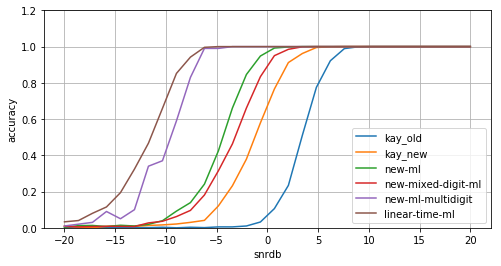

In [204]:
rs = np.array(rs)
rs_kay1 = np.array(rs_kay1)
# rs_2 = np.array(rs_2)
rs_3 = np.array(rs_3)
rs_ml = np.array(rs_ml)
rs_mixed = np.array(rs_mixed)
# rs_true_ml = np.array(rs_true_ml)
rs_linear_ml = np.array(rs_linear_ml)

plt.figure(figsize=(8,4))

plt.plot(snrdb_points, rs_kay1, label='kay_old')
plt.plot(snrdb_points, rs, label='kay_new')
plt.plot(snrdb_points, rs_ml, label='new-ml')
plt.plot(snrdb_points, rs_mixed, label='new-mixed-digit-ml')
plt.plot(snrdb_points, rs_3, label='new-ml-multidigit')
plt.plot(snrdb_points, rs_linear_ml, label='linear-time-ml')

# plt.plot(snrdb_points, rs_2, label='sub-ml')

# plt.plot(snrdb_points, rs_true_ml, label='true-ml')
# plt.plot(snrdb_points, rs_mixed, label='mixed-ml')

# plt.axvline(6, c='r')

# plt.gca().set_yscale('log')

plt.xlabel('snrdb')
plt.ylabel('accuracy')
plt.legend()
plt.ylim([0,1.2])
plt.grid(True)
plt.savefig('comparison.pdf')
plt.show()

20 bits

1 bits x 20 times : new-ml

20*2 = 40

5 bits x 4 times: new-ml-multidigit

2^20 / 2^5 = 2^15

4 * 2^5 = 128

20 bits x 1 times: linear-time-ml
2^20 = 1M

In [ ]:
(64*20)/(2**20)

In [ ]:
rs = np.array(rs)
rs_2 = np.array(rs_2)
rs_3 = np.array(rs_3)
rs_ml = np.array(rs_ml)
rs_mixed = np.array(rs_mixed)
rs_true_ml = np.array(rs_true_ml)

plt.plot(snrdb_points, to_db(np.log(1/(1-rs))), label='kay')
# plt.plot(snrdb_points, rs_2, label='sub-ml')
# plt.plot(snrdb_points, rs_3, label='sub-ml-multidigit')
plt.plot(snrdb_points, to_db(np.log(1/(1-rs_ml))), label='ml')
plt.plot(snrdb_points, to_db(np.log(1/(1-rs_true_ml))), label='true-ml')
# plt.plot(snrdb_points, rs_mixed, label='mixed-ml')
# plt.axvline(6, c='r')
plt.xlabel('snrdb')
plt.ylabel('accuracy')
plt.legend()
# plt.ylim([0,1.2])
plt.grid(True)
plt.show()

### kays as a function of the number of samples

In [ ]:
p = 2
n = 20
f0 = 1

num_samples_vec = np.arange(5,100,15)
results_vec = []
for num_samples in tqdm(num_samples_vec):
    r = run_many(test_kays, 5000, p=p, n=n, num_samples=num_samples, f0=f0, snrdb=0)
    var_output = np.mean((np.array(r) - 2*np.pi*f0/(p**n))**2)
    results_vec.append(var_output)
    # print('var: {}'.format( var_output ))

results_vec = np.array(results_vec)

In [ ]:
plt.plot(num_samples_vec, to_db(1/results_vec))
plt.show()

# fixed snr plots

In [ ]:
m_points = 2**np.arange(1,7)

In [ ]:
p = 2
n = 20
f0 = 0
N = p**n
snrdb = -10

rs_ml = []
for m in tqdm(m_points):
    # Sub-ML multi-period
    q = run_many(test_sub_ml, 100, p=p, n=n, samples_per_chain=m, num_chains=1,
                 f0=f0, snrdb=snrdb, summing_power=2, alternate=False)
    rs_ml.append(np.mean(q))

In [ ]:
p = 2
n = 20
f0 = 0
N = p**n
snrdb = -10

rs_linear_ml = []
for m in tqdm(m_points):
    # Sub-ML multi-period
    q = run_many(test_linear_ml, 100, p=p, n=n, samples_per_chain=m*n, f0=f0, snrdb=snrdb)
    rs_linear_ml.append(np.mean(q))

In [ ]:
rs_ml = np.array(rs_ml)
rs_linear_ml = np.array(rs_linear_ml)

plt.plot(m_points*n, rs_ml, label='ml')
plt.plot(m_points*n, rs_linear_ml, label='linear-time-ml')
# plt.axvline(6, c='r')
plt.xlabel('m')
plt.ylabel('accuracy')
plt.legend()
plt.ylim([0,1.2])
plt.grid(True)
plt.savefig('comparison.pdf')
plt.show()

In [ ]:
s2 = 10**(-snrdb/10)
9*n*np.log(n)*s2/(p**n)

# fix snr + change n > find m

In [ ]:
import pandas as pd

In [ ]:
m_points = np.arange(2,64,2)
print(m_points)

In [ ]:
# p = 2
# f0 = 0
# snrdb = 0


# df_linear_ml = pd.DataFrame(columns=['n', 'samples', 'acc'])
# for n in tqdm(np.arange(20,50,5), leave=False):
#     N = p**n
#     for m in tqdm(m_points):
#         # Sub-ML multi-period
#         num_samples = m*n
#         q = run_many(test_linear_ml, 10, p=p, n=n, samples_per_chain=num_samples, f0=f0, snrdb=snrdb)
        
#         acc_hat = np.mean(q)
        
#         entry = {'n':n, 'samples':num_samples, 'acc':acc_hat}
#         df_linear_ml = df_linear_ml.append(entry, ignore_index=True)
# #         if acc_hat == 1:
# #             break

In [ ]:
p = 2
f0 = 0
snrdb = -5

try:
    df_ml
except NameError: 
    df_ml = pd.DataFrame(columns=['n', 'samples', 'acc', 'snrdb'])

m_min = 32
m_max = 128
for n in tqdm(np.arange(10,60,5)):
    N = p**n
    m_points = np.arange(m_min, m_max, 2)
    for m in tqdm(m_points, leave=False, desc='n: {}'.format(n)):
        # Sub-ML multi-period
        num_samples = m*n
        q = run_many(test_sub_ml, 5000, p=p, n=n, samples_per_chain=m, num_chains=1,
                 f0=f0, snrdb=snrdb, summing_power=2, alternate=False)
        acc_hat = np.mean(q)
        entry = {'n':n, 'samples':num_samples, 'acc':np.mean(q), 'snrdb':snrdb}
        df_ml = df_ml.append(entry, ignore_index=True)
        if acc_hat < 0.8:
            m_min = m
        if acc_hat == 1:
            break

In [ ]:
df_ml

In [ ]:
p = 2
f0 = 0
snrdb = -5

try:
    df_kay
except NameError: 
    df_kay = pd.DataFrame(columns=['n', 'samples', 'acc', 'snrdb'])

m_min = 160
m_max = 300
for n in tqdm(np.arange(10,60,5)):
    N = p**n
    m_points = np.arange(m_min, m_max, 2)
    for m in tqdm(m_points, leave=False, desc='n: {}'.format(n)):
        # Sub-ML multi-period
        num_samples = m*n
        q = run_many(test_successive_estimation, 5000, p=p, n=n,
                     samples_per_chain=m, num_chains=n, f0=f0, snrdb=snrdb)
        
        acc_hat = np.mean(q)
        entry = {'n':n, 'samples':num_samples, 'acc':np.mean(q), 'snrdb':snrdb}
        df_kay = df_kay.append(entry, ignore_index=True)
        if acc_hat < 0.8:
            m_min = m
        if acc_hat == 1:
            break

In [ ]:
q = run_many(test_successive_estimation, 5000, p=p, n=n,
                     samples_per_chain=200, num_chains=n, f0=f0, snrdb=snrdb)

print(np.mean(q))

In [ ]:
m

In [ ]:
def get_samples_for_acc(df, acc, snrdb):
    n_vec = []
    s_ml_vec = []
    df_subset = df[df['snrdb']==snrdb]
    for g, v in df_subset.groupby('n'):
        samples_enough = v.iloc[np.where(v['acc'] > acc)[0][0]]['samples']
        n_vec.append(g)
        s_ml_vec.append(samples_enough)
    n_vec = np.array(n_vec)
    s_ml_vec = np.array(s_ml_vec)
    return (2**n_vec, s_ml_vec)

In [ ]:
df_kay = df_kay[~((df_kay['snrdb']==-5) & (df_kay['n'] ==30))]

In [ ]:
from matplotlib.ticker import LogFormatterExponent

In [ ]:
df_ml.to_pickle('df_ml_m_vs_n.pickle')

In [ ]:
df_kay.to_pickle('df_kay_m_vs_n.pickle')

In [ ]:
fig1, ax1 = plt.subplots(figsize=(6,3.5))

ax1.plot(*get_samples_for_acc(df_ml, 0.99, 0), '*-', label='this paper (0dB)')
ax1.plot(*get_samples_for_acc(df_kay, 0.99, 0), 'x-', label='s.e. (0dB)')

ax1.plot(*get_samples_for_acc(df_ml, 0.99, -5), '*-', label='this paper (-5dB)')
ax1.plot(*get_samples_for_acc(df_kay, 0.99, -5), 'x-', label='s.e. (-5dB)')

ax1.set_xscale('log', basex=2)
ax1.set_xticks(2**np.arange(10,60,5))
# ax1.get_xaxis().set_major_formatter(LogFormatterExponent(base=2))

plt.xlabel('N')
plt.ylabel('number of samples')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('manuscript/figures/m-vs-n.pdf')
plt.show()

In [ ]:
for i in 2**np.arange(10,60,5):
    print('{},'.format(i), end=' ')

In [ ]:
a = get_samples_for_acc(df_ml, 0.99, 0)
# ax1.plot(*get_samples_for_acc(df_kay, 0.99, 0), 'x-', label='s.e. (0dB)')

# ax1.plot(*get_samples_for_acc(df_ml, 0.99, -5), '*-', label='this paper (-5dB)')
# ax1.plot(*get_samples_for_acc(df_kay, 0.99, -5), 'x-', label='s.e. (-5dB)')

In [ ]:
write_data('m-vs-n-ml-0.txt', ['n', 'm'], *get_samples_for_acc(df_ml, 0.99, 0))

In [ ]:
write_data('m-vs-n-ml-5.txt', ['n', 'm'], *get_samples_for_acc(df_ml, 0.99, -5))

In [ ]:
write_data('m-vs-n-kay-0.txt', ['n', 'm'], *get_samples_for_acc(df_kay, 0.99, 0))

In [ ]:
write_data('m-vs-n-kay-5.txt', ['n', 'm'], *get_samples_for_acc(df_kay, 0.99, -5))

# Testing successive estimation

In [ ]:
# for testing the successive estimation or kay's method
n = 20
p = 2
f0 = 0
snrdb = 10

N = p**n
w0 = (2*np.pi)*f0/N

# odd number of delays are not working
# fix this
num_delays_per_chain = 2

num_correct = 0
num_iter = 1000

# num_chains = int(np.log2(N))
num_chains = n

total_samples = num_chains*num_delays_per_chain
print('total samples: {}'.format(total_samples))

a_list = []

for i in tqdm(range(num_iter)):
    # successive estimation ----
    A = make_kay_chains(w0,
                        num_chains,
                        num_delays_per_chain,
                        snrdb)
    # the one used in ffast paper
    a = successive_estimation(A, N)
    a_list.append(a)
    # --------------------------
    
    # original kay's method ----
#     a = omega_to_location(kays_method(make_kay_chains(w0, 1, total_samples, snrdb)[0]),N)
    # --------------------------
    
    b = round(a) % N
    num_correct += (b == f0)
    
print('success: {}'.format(num_correct/num_iter))

In [ ]:
omega_to_location(kays_method(A[0]),N)

In [ ]:
noise_number = 4060
vnoise = make_noise(get_sigma2_from_snrdb(0),noise_number)
np.sum(np.abs(vnoise)**2)/noise_number

In [ ]:
# kay with only possible locations active
F1 = 32
F2 = 25*27
N = F1*F2

print("N: {}".format(N))

f0 = np.random.choice(N)
# f0 = 32

print('f0: {}'.format(f0))

print('dbgain: {}'.format(10*np.log10(F1)))

bin_relative_index = f0 % F1

w0 = (2*np.pi)*f0/N
snrdb = 0

num_correct = 0
num_iter = 5000

num_delays_per_chain = 3
num_chains = 4

total_samples = num_chains*num_delays_per_chain
print('total samples: {}'.format(total_samples))

for i in tqdm(range(num_iter)):
    # successive estimation ----
    A = make_kay_chains(w0,
                        num_chains,
                        num_delays_per_chain,
                        snrdb+10*np.log10(F1))
    
    # the one used in ffast paper
    r = successive_estimation(A,N,rounding=(bin_relative_index,F1))    
    b = r
    
#     print(b)
    
    num_correct += (b == f0)
    
print('success: {}'.format(num_correct/num_iter))

# explorations to understand things

## Explore dependent or independent sampling

In [ ]:
n = 1
p = 3
N = p**n
f0 = 0
w0 = (2*np.pi)*f0/N
snrdb = -3
num_iter = 5000


num_chains = n


pairs_per_chain = 8*p
num_samples_per_pair = 2

total_delays = pairs_per_chain*num_samples_per_pair

sub_ml_numpairs = (pairs_per_chain*num_samples_per_pair)//p

print('total dealys: {}'.format(total_delays))

In [ ]:
def value_to_bit(v,p):
    return int(p*((np.angle(v*np.exp(1j*np.pi/p))/2/np.pi)%1))

In [ ]:
total_error = 0

z_vec_indep = []
for i in range(num_iter):
    A,B = make_our_chains(w0=w0,
                          n=num_chains,
                          num_pairs_per_chain=pairs_per_chain,
                          snrdb=snrdb,
                          prime_base=p,
                          num_samples_per_pair=num_samples_per_pair)
    
    
    z = 0
    c = 0

    # go through only the first chain
    for x in A[0]:
        a,b = x
        c +=1
        z += b*np.conj(a)
    z /= c
    z_vec_indep.append(z)
    total_error += np.abs(z-1)**2


    
preds = [value_to_bit(zi,p) for zi in z_vec_indep]
print('wrong class: {0:.2f}%'.format(100*np.mean( np.array(preds) != f0)))

In [ ]:
total_error = 0

z_vec_dep = []

for i in range(num_iter):
    A,B = make_our_chains(w0=w0,
                          n=num_chains,
                          num_pairs_per_chain=1,
                          snrdb=snrdb,
                          prime_base=p,
                          num_samples_per_pair=total_delays)
    
    z = 0
    
    x = np.array(A[0][0])
    
    c = len(x)-1
    
    phases_vec = np.array(x[1:])*np.conj(x[0:-1])
    z = np.sum(phases_vec)/c
    
#     z = kay_weights(c+1).dot(phases_vec
    
    z_vec_dep.append(z)
    
    total_error +=np.abs(z - 1)**2

preds = [value_to_bit(zi,p) for zi in z_vec_dep]
print('wrong class: {0:.2f}%'.format(100*np.mean( np.array(preds) != f0)))

In [ ]:
total_error = 0

z_vec_ml = []

for i in range(num_iter):
    A,B = make_our_chains(w0=w0,
                          n=num_chains,
                          num_pairs_per_chain=1,
                          snrdb=snrdb,
                          prime_base=p,
                          num_samples_per_pair=total_delays)
    
    r = our_method(A,
                   B,
                   prime_base=p,
                   bin_estimator=estimate_bit_ml)
    z = np.exp(1j*r)
    
    
    z_vec_ml.append(z)
    
    total_error +=np.abs(z - 1)**2

preds = [value_to_bit(zi,p) for zi in z_vec_ml]
print('wrong class: {0:.2f}%'.format(100*np.mean( np.array(preds) != f0)))

In [ ]:
total_error = 0

z_vec_sub_ml = []

print('num pairs: {}'.format(sub_ml_numpairs))

new_estimator = lambda chain, sampling_points, ref_w0, prime_base: estimate_bit_sub_ml(chain,
                        sampling_points,
                        ref_w0,
                        prime_base,
                        summing_power=1)

for i in range(num_iter):
    A,B = make_our_chains(w0=w0,
                          n=num_chains,
                          num_pairs_per_chain=sub_ml_numpairs,
                          snrdb=snrdb,
                          prime_base=p,
                          num_samples_per_pair=p)
    
    r = our_method(A,
                   B,
                   prime_base=p,
                   bin_estimator=new_estimator)
    z = np.exp(1j*r)
    
    
    z_vec_sub_ml.append(z)
    
    total_error +=np.abs(z - 1)**2

preds = [value_to_bit(zi,p) for zi in z_vec_sub_ml]
print('wrong class: {0:.2f}%'.format(100*np.mean( np.array(preds) != f0)))

In [ ]:
num_correct = 0

num_delays_per_chain = num_pairs_per_chain*num_samples_per_pair

print('total samples: {}'.format(num_delays_per_chain))

z_vec_kay = []

for i in tqdm(range(num_iter)):
    # successive estimation ----
    A = make_kay_chains(w0=w0,
                        num_chains=num_chains,
                        num_samples_per_chain=total_delays,
                        snrdb=snrdb)
    
    # the one used in ffast paper
    r = kays_method(A[0],simple_average=False)
    
    z_vec_kay.append( np.exp(1j*r) )    

preds = [value_to_bit(zi,p) for zi in z_vec_kay]
print('wrong class: {0:.2f}%'.format(100*np.mean( np.array(preds) != f0)))

In [ ]:
plt.figure(figsize=[10,10])
ax = plt.subplot(111, projection='polar')


ax.scatter(np.angle(z_vec_indep),np.abs(z_vec_indep),label='indep',alpha=0.5)
ax.scatter(np.angle(z_vec_dep),np.abs(z_vec_dep),label='dep',alpha=0.5)

ax.scatter(np.angle(z_vec_kay),2*np.abs(z_vec_kay),label='kay',alpha=0.5,c='k')
ax.scatter(np.angle(z_vec_ml), 4*np.abs(z_vec_ml), marker='s', s=100, label='ml', c='C5',alpha=1)


ax.set_rticks([1, 2, 3, 4])  # less radial ticks
ax.set_rlabel_position(-180/p)  # get radial labels away from plotted line

ax.set_thetagrids(np.arange(0,2*p)*180/p)

ax.grid(True)

plt.legend()
plt.axvline(0,linestyle='--')
plt.show()

# method with multiple factors

In [ ]:
# for testing our method
p1 = 2
n1 = 2

p2 = 3
n2 = 2

N = (p1**n1)*(p2**n2)

f0 = 3
w0 = (2*np.pi)*f0/N

signal = np.exp(1j*w0*np.arange(N))

num_pairs_per_chain = 1
print(num_pairs_per_chain)

num_correct = 0
num_iter = 500

# total_samples = n*2*num_pairs_per_chain
# print('total samples: {}'.format(total_samples))


# we want to find it with respect to p2
B = make_our_locations(n2,1,p2,2,p1**n1)

observation_matrix = []

# go through each chain
for chain in B:
    print('chain')
    # go through each delay
    for d0,d1 in chain:
        # downsample the signal
        subsampling_locations = (int(d0) + np.arange(0,N,p2**n2)) % N
        subsampled_signal = signal[subsampling_locations]
        observation_matrix.append(np.fft.fft(subsampled_signal))
        
        subsampling_locations = (int(d1) + np.arange(0,N,p2**n2)) % N
        subsampled_signal = signal[subsampling_locations]
        observation_matrix.append(np.fft.fft(subsampled_signal))



target_bin = f0 % (p1**n1)
rotate = np.exp(1j*np.pi/p2)

print(np.abs(observation_matrix[0][target_bin]))


v1 = np.conj(observation_matrix[0][target_bin])*observation_matrix[1][target_bin]

angle1 = np.angle(rotate*v1)/2/np.pi % 1
a = int(angle1*p2) % p2

v2 = np.conj(observation_matrix[2][target_bin])*observation_matrix[3][target_bin]
v2 = v2*np.exp(-1j*2*np.pi*a/(p2**n2))

angle2 = np.angle(rotate*v2)/2/np.pi % 1
b = int(angle2*p2) % p2


print('bit0: {}'.format(a))
print('bit1: {}'.format(b))

print('truth: {}'.format(f0%(p2**n2)))

# Batch testing

In [ ]:
def test_mse(w0,N,snrdb,ITER):
    signal = make_signal(w0,0,N)
    mse = 0
    sigma2 = get_sigma2_from_snrdb(snrdb)
    for i in range(ITER):
        noise = make_noise(sigma2, N)
        noisy_signal = signal + noise    
        w_est = kays_method(noisy_signal)
        squared_error = (w_est - w0)**2
        mse += squared_error/ITER
    return mse

In [ ]:
# kay's plots
w0 = 2*np.pi*0.05
N  = 24

mse = test_mse(w0, N, 10, 400)

10*np.log10(1/mse)

# Calculations for deriving bounds for Kay-like averaging

In [ ]:
A = np.array([[1, 0.5, 0.5],[0.5, 0, 0.5],[0.5,0.5,0]])
A

In [ ]:
import scipy.linalg as linalg

In [ ]:
Z = np.diag([1.5, -.5])
Z

In [ ]:
U = np.array([[2/np.sqrt(6),1/np.sqrt(6),1/np.sqrt(6)],[0,-1/np.sqrt(2),1/np.sqrt(2)]]).T
U

In [ ]:
U.dot(Z).dot(U.T)

In [ ]:
A = np.array([[0,0.5],[0.5,0]])
A

In [ ]:
Z2, U2 = np.linalg.eig(A)
Z2 = np.diag(Z2)

In [ ]:
U2.dot(Z2).dot(U2.T)

In [ ]:
x = np.linspace(0,1,100)[:-1]
x

In [ ]:
a = 3
x = np.linspace(0,1/a,100)[:-1]
z = [(1-3*u)/(1-u) for u in x]

In [ ]:
plt.plot(x,z)

In [ ]:
# bound on sqrt part
a = 100
x = np.linspace(0,1/a,100)[:-1]
z = [1/np.sqrt(1-2*u) for u in x]
y = [np.exp(u + 10*u**2) for u in x] 

plt.plot(x,z,label='truth')
plt.plot(x,y,label='bound')
plt.legend()
plt.show()

In [ ]:
# bound on new part
alpha = 2

a = 4*alpha
x = np.linspace(0,1/a,100)[:-1]



z = [(1-2*u*alpha)/(1-2*u) for u in x]
y = [1-2*alpha*u for u in x] 

plt.plot(x,z,label='truth')
plt.plot(x,y,label='bound')
plt.axhline(1/2,linestyle='--',c='r')
plt.legend()
plt.show()

In [ ]:
a = -1
A = np.array([[2,a,0],[a,2,a],[0,a,2]])
print(A)
              

np.sum(np.linalg.inv(A))

In [ ]:
a = -1
A = np.array([[1,0],[0,1]])

np.sum(np.linalg.inv(A))

In [ ]:
def our_soft_max(u,l=1):
    return np.sum(u*np.exp(l*u))/np.sum(np.exp(l*u))

In [ ]:
our_soft_max(np.array([1,2,3.9,4]),100)

In [ ]:
np.log((45276-44988)/32)/np.log(3)

# Bound on the mgf of non-central chi-squared

In [ ]:
mu2 = 20

t = np.linspace(0,1/4,100)[:-1]

log_mgf = mu2*t/(1-2*t) - 0.5*np.log(1-2*t) - t*(mu2+1)

bound = (2+4*mu2)*(t**2)

plt.plot(t, log_mgf, label='truth')
plt.plot(t, bound, label='bound')
plt.axvline(1/4, c='C2')
plt.legend()
plt.show()

In [ ]:
t = np.linspace(0,1/3,100)[1:-1]

u = 4

y = (1/(1-2*t) -1)
yb = u*t

plt.plot(t, y, label='truth')
plt.plot(t, yb, label='bound')
plt.axvline((u-2)/(2*u), c='C2')
plt.legend()
plt.show()

# expectation stuff

In [ ]:
ITER = 100000
a = 0
v = 0.1
for i in range(ITER):
    a += np.sqrt((v+np.random.randn())**2 + np.random.randn()**2)/ITER

a - np.sqrt(np.pi/2)
# a

In [ ]:
np.sqrt(np.pi/2)

In [ ]:
np.sqrt(np.exp(1))

In [ ]:
ipdb

In [ ]:
import tensorflow

In [ ]:
b = tensorflow.constant(np.random.randn(3,3,3))

In [ ]:
b[:,:,0]

In [ ]:
from scipy.optimize import fsolve



In [ ]:
@np.vectorize
def find_M(u, num_iter = 30):
    below = np.log(1/u)
    above = 1/u
    
    def f(x):
        return x - np.log(x/u)
    
    for i in range(num_iter):
        mid = 0.5*(above+below)
        v = f(mid)
        if v > 0:
            above = mid
        elif v < 0:
            below = mid
        else:
            return mid
    return above

In [ ]:
def f(x, u):
    return x - np.log(x/u)

In [ ]:
q = 0.5
f(1.2, q)

In [ ]:
np.log(np.log(2))

In [ ]:
a = find_M(0.1)

In [ ]:
a - np.log(a/0.1)

In [ ]:
?np.logspace

In [ ]:
?np.logspace

In [ ]:
u = np.logspace(-5,-1,100,base=np.exp(1))
# u = np.linspace(0,1/np.exp(1),400)[1:-1]
M = find_M(u)

In [ ]:
plt.semilogx(u, M/np.log(1/u))
# plt.plot(u, M - np.log(M/u))
plt.show()

In [ ]:
1/np.exp(1)

In [ ]:
t = np.linspace(0,10)[1:-1]
y1 = np.log(2*t+1)
y2 = t
plt.plot(t,y1,label='truth')
plt.plot(t,y2,label='bound')
plt.show()

In [ ]:
t = np.linspace(0,1,100)[1:-1]
y1 = t*np.log(t)+t
plt.plot(t,y1,label='truth')
plt.show()

# some tests

In [ ]:
@np.vectorize
def fun(x, a):
    return (x**2/a**2)/(1+x/a)

In [ ]:
t = np.logspace(0,6,100)
y = fun(t,1e3)

In [ ]:
plt.loglog(t,y)
plt.grid()
plt.axvline(1e3, color='red', linestyle='--')
plt.show()

In [ ]:
@np.vectorize
def fun2(x, a, b):
    return x/a - np.log(x/b)

@np.vectorize
def fun2(x, a, b):
    return x/a - np.log(x/b)

In [ ]:
t = np.linspace(0,100,100)
a = 9
b = 0.1
y = fun2(t,a,b)

min_val = 1 - np.log(a/b)

plt.plot(t,y)
plt.grid()
plt.axvline(18*np.log(a/b), color='C1', linestyle='--')
plt.axhline(min_val, color='C2', linestyle='--')
plt.show()